# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 1: Bag-of-Words based Natural Language Inference (30 pts)

In this assignment, you will train a Bag-of-Words encoder to tackle the Stanford Natural Language Inference (SNLI) task.

We have 5 coding questions and 3 written questions. Some coding functions are provided for your reference, but you are welcome to change and write your own functions. You should deliver your training and validation results in written questions.

In [1]:
# Import required packages
import os 
import numpy as np
import pickle as pkl
from collections import Counter

import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

In [2]:
# save index 0 for unk and 1 for pad
global PAD_IDX, UNK_IDX
UNK_IDX = 0
PAD_IDX = 1

---
### 1 Dataset (6 pts)
#### Data Processing

In [3]:
# Read data
# tokenized data provided or you can tokenize data by your self
folder = os.getcwd() + '/data_after_process/'

## update: filp hypo <-> prem
prem_data_tokens_train = pkl.load(open(folder+"hypo_data_tokens_train.p", "rb"))
hypo_data_tokens_train = pkl.load(open(folder+"prem_data_tokens_train.p", "rb"))

prem_data_tokens_val = pkl.load(open(folder+"hypo_data_tokens_val.p", "rb"))
hypo_data_tokens_val = pkl.load(open(folder+"prem_data_tokens_val.p", "rb"))

label_index_train = pkl.load(open(folder+"label_index_train.p", "rb"))
label_index_val = pkl.load(open(folder+"label_index_val.p", "rb"))

**Coding 1: finish `build_vocab` function** (2 pts)


In [4]:
def build_vocab(hypo_tokens, prem_tokens, max_vocab_size=10000):
    # TODO:
    # build vocab
    # returns: 
    # - id2token: list of tokens, where id2token[i] returns token that corresponds to token i
    # - token2id: dictionary where keys represent tokens and corresponding values represent indices
            
    # first, merge two word of lists 
    hypo_prem_tokens = hypo_tokens + prem_tokens
    
    # for given hypo_tokens and prem tokens, tokenize every word
    all_tokens = [token for tokens in hypo_prem_tokens for token in tokens]    
    
    # this makes {word: count} pairs of given list
    token_counter = Counter(all_tokens)
    
    # calling most_common function to filter by most common max_vocab_size word
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    
    # we need to create its index, so create a dictionary 
    token2id = dict(zip(vocab, range(2, 2+len(vocab))))
    
    # assigning index of unk and pad as 0 and 1
    token2id["<UNK>"] = UNK_IDX
    token2id["<PAD>"] = PAD_IDX

    # for the rest of the vocab, add after unk and pad
    id2token = ["<UNK>", "<PAD>"] + list(vocab)
    
    return token2id, id2token    

**Coding 2: finish `token2index` function** (2 pts)

In [5]:
def token2index(tokens_data):
    # TODO:
    # convert token to id in the dataset
    # returns:
    # - indices_data: return list of index_list (index list for each sentence)
    
    # create an empty list for the return
    index_list = []
    
    # for each sentence, iterate once again for each word and get the index
    # if not, give 0 as UNX is defined as index 0
    # also note that this function uses global variable of token2id (which should be predefined in 'build_vocab')
    for sentence in tokens_data:
        indexes = [token2id.get(token, 0) for token in sentence]
        index_list.append(indexes)
    
    return index_list

In [6]:
token2id, id2token = build_vocab(hypo_data_tokens_train, prem_data_tokens_train, max_vocab_size=10000)
hypo_data_indices_train = token2index(hypo_data_tokens_train)
prem_data_indices_train = token2index(prem_data_tokens_train)
hypo_data_indices_val = token2index(hypo_data_tokens_val)
prem_data_indices_val= token2index(prem_data_tokens_val)  

#### DataLoader

**Coding 3: finish DataLoader** (2 pts)

In [7]:
def newsgroup_collate_func(batch):
    """
    Customized function for DataLoader that dynamically pads the batch so that all
    data have the same length
    """
    hypo_list = []
    len_hypo_list = []
    prem_list = []
    len_prem_list = []
    label_list = []

    for datum in batch:
        label_list.append(datum[4])
        len_hypo_list.append(datum[1])
        len_prem_list.append(datum[3])
    # padding
    for datum in batch:
        ## update: constant should be PAD_IDX
        # hypo
        padded_vec = np.pad(np.array(datum[0]), pad_width=((0,max_sentence_length-datum[1])), mode="constant", constant_values=PAD_IDX)
        hypo_list.append(padded_vec)
        # prem
        padded_vec = np.pad(np.array(datum[2]), pad_width=((0,max_sentence_length-datum[3])), mode="constant", constant_values=PAD_IDX)
        prem_list.append(padded_vec)
    return [torch.from_numpy(np.array(hypo_list)), torch.LongTensor(len_hypo_list), 
            torch.from_numpy(np.array(prem_list)), torch.LongTensor(len_prem_list), torch.LongTensor(label_list)]

In [8]:
class NewsGroupDataset(Dataset):
    """
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """

    def __init__(self, hypo_list, prem_list, target_list, max_sentence_length):
        """
        @param hypo_list: list of hypo tokens
        @param prem_list: list of prem tokens
        @param target_list: list of newsgroup targets
        @param max_sentence_length: fixed length of all sentence
        """
        self.hypo_list = hypo_list
        self.prem_list = prem_list
        self.target_list = target_list
        self.max_sentence_length = max_sentence_length
        assert (len(self.hypo_list) == len(self.target_list))
        assert (len(self.prem_list) == len(self.target_list))
        
    def __len__(self):
        return len(self.hypo_list)

    def __getitem__(self, key):
        """
        Triggered when you call dataset[i]
        """
        token_hypo_idx = self.hypo_list[key][:self.max_sentence_length]
        token_prem_idx = self.prem_list[key][:self.max_sentence_length]
        label = self.target_list[key]
        return [token_hypo_idx, len(token_hypo_idx), token_prem_idx, len(token_prem_idx), label]

In [9]:
max_sentence_length = 20

train_dataset = NewsGroupDataset(hypo_data_indices_train, prem_data_indices_train, label_index_train, max_sentence_length)
val_dataset = NewsGroupDataset(hypo_data_indices_val, prem_data_indices_val, label_index_val,max_sentence_length)

In [10]:
# TODO:
# finish DataLoader

# import DataLoader library
from torch.utils.data import DataLoader

# create a dictionary that would be including both train / val 
newsgroup_loaders = {}

# assuming a batch size of 1024 (this was given number, but can be changed)
batch_size = 1024

# we assign train, validation dataset to DataLoader so that we can have about 782 data that has 1024 batch each 
newsgroup_loaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, \
                                      collate_fn=newsgroup_collate_func)

newsgroup_loaders['validation'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, \
                                      collate_fn=newsgroup_collate_func)

---
### 2 Model (8 pts)

We will use a BoW encoder to map each string of text (hypothesis and premise) to a fixed-dimension vector representation. At this point, we have one vector representation corresponding to hypothesis and one for premise. 

We will interact the two representations and perform classification on this. For combining the two vector representations, you should try at least methods: concatenate, sum, and element-wise product. 

Once we’ve the combined representation, we will to do a 3-class classification Logistic Model on this input vector. 

**Coding 4: finish `LogisticsModelPytorch` Class** (code from the labs may be helpful). (8 pts)

In [11]:
class LogisticsModelPytorch(nn.Module):

    def __init__(self, vocab_size, emb_dim, n_out, reduce):
        """
        @param vocab_size: size of the vocabulary.
        @param emb_dim: size of the word embedding.
        @param n_out: size of the class.
        @param reduce: interaction type: [sum, concat, element-wise].
        """
        
        super(LogisticsModelPytorch, self).__init__()
        
        # TODO:         
        # 1. Embedding: make sure that you are using padding_idx as PAD_IDX
        self.embedder = nn.Embedding(vocab_size, emb_dim, padding_idx = PAD_IDX)     
        
        # 2. define reduce 
        # if reduce is concat, we need to change emb_dim size multiplied by 2 as this will change emd dimension 
        self.reduce = reduce       
        if self.reduce == 'concat': emb_dim *= 2
            
        # 3. Linear Layers
        self.linear = nn.Linear(emb_dim, n_out)
        
        # 4. define a softmax function to convert nn result into log-probability distribution over classes
        # not using this based on the campuswire comment by TA
        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, data_hypo, length_hypo, data_prem, length_prem):
        """
            @param data_hypo: matrix of size (batch_size, max_sentence_length). Each row in data represents a
            review that is represented using n-gram index. Note that they are padded to have same length.
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
            length of each sentences in data_hypo.
            @param data_prem: matrix of size (batch_size, max_sentence_length).
            @param length_hypo: an int tensor of size (batch_size), which represents the non-trivial (excludes padding)
                length of each sentences in data_prem.
            """
        
        # TODO:
        # word embedding
        # combine to sentence 

        # first, we embedd each hypo, prem 
        # before moving on to the interaction, you should get a vector instead of getting a list of values 
        # for each sentence, get an average of words (should be a vector) 
        embedding_hypo = self.embedder(data_hypo)
        embedding_hypo = torch.sum(embedding_hypo, dim=1) / length_hypo.unsqueeze(1)

        embedding_prem = self.embedder(data_prem)
        embedding_prem = torch.sum(embedding_prem, dim=1) / length_prem.unsqueeze(1)     
        
        # interaction
        # 1. sum
        # 2. Hadamard (element-wise) product
        # 3. concat (This will change embedding dimension, 2 times as many as before)        
        if self.reduce == 'concat':        
            out = torch.cat((embedding_hypo, embedding_prem), dim=1)
        if self.reduce == 'sum':
            out = embedding_hypo + embedding_prem
        if self.reduce == 'hadamard':
            out = embedding_hypo * embedding_prem
        
        # linear projection 
        out = self.linear(out)     

        return out        

---
### 3 Training and Validation (16 pts)

Train your model in different settings. 

Perform tuning over at least two of the following hyperparameters:
1. vocab size in `build_vocab` function
2. embedding size in `LogisticsModelPytorch` class
3. SGD vs Adam
4. learning rate in training

**For interaction type `reduce`, you need to try at least two methods: sum, element-wise product, and concatenation.** 



**Coding 5: finish training and validation** (4 pts)

The following incomplete code can get you started on your train loop. Feel free to modify the function signature to pass any arguments needed for the training.

In [12]:
# import this library to see the progress of the model
from tqdm.auto import tqdm

def train(model):
    
    # initialize variables that would be used in the plot 
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    # iterate each epoch 
    for epoch in tqdm(range(num_epochs)):
        
        # initialization of variables
        train_losses_batch = []
        train_accs_batch = []        
        
        # iterate each batch
        for _, (hypo, len_hypo, prem, len_prem, label) in enumerate(newsgroup_loaders['train']):  
            
            # Always zero-out the gradients managed by your optimizer
            optimizer.zero_grad()   
            
            # train the model
            model.train()
            
            # run the model and calculate the loss by comparing predictions with actual labels 
            prob = model(hypo, len_hypo, prem, len_prem)            
            train_loss = criterion(prob, label)
            
            # also compute acc as this is also assigned as evaluation criteria
            # make sure that you convert the probability into prediction by taking argmax
            pred = torch.argmax(prob, dim=1)            
            train_acc = (pred == label.view_as(pred)).sum().item() / label.shape[0]     
            
            # Back-propagate the gradients to the parameters
            train_loss.backward()
            
            # Apply the gradient updates to the parameters
            optimizer.step()
            
            # add batch result
            train_losses_batch.append(train_loss.item())
            train_accs_batch.append(train_acc)
            
        # add epoch result by avearging batch result
        train_losses.append((sum(train_losses_batch) / len(newsgroup_loaders['train'])))
        train_accs.append((sum(train_accs_batch) / len(newsgroup_loaders['train'])))  
            
        #### validation set     
        # initialization of variables
        val_losses_batch = []
        val_accs_batch = []
        
        # evaluation mode
        model.eval()
        
        # we just want to evaluate the result, but not updating 
        with torch.no_grad():
            for batch, (hypo, len_hypo, prem, len_prem, label) in enumerate(newsgroup_loaders['validation']):

                # run the model for validation set and also evaluatwe
                prob = model(hypo, len_hypo, prem, len_prem)
                val_loss = criterion(prob, label)                
                
                pred = torch.argmax(prob, dim=1)   
                val_acc = (pred == label.view_as(pred)).sum().item() / label.shape[0]
                
                # add batch result 
                val_losses_batch.append(val_loss.item())
                val_accs_batch.append(val_acc)
            
            # add epoch result
            val_losses.append((sum(val_losses_batch) / len(newsgroup_loaders['validation'])))
            val_accs.append((sum(val_accs_batch) / len(newsgroup_loaders['validation'])))               
        
        # print result
        print('epoch {}) train_loss: {:.3f}, train_acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}'\
              .format((epoch+1), train_losses[-1], train_accs[-1], val_losses[-1], val_accs[-1])) 
        
    # save as a dictionary
    res = {'train_losses':train_losses,
                'train_accs':train_accs,
                'val_losses':val_losses,
                'val_accs':val_accs}
    
    # return result
    return res                       

### Conducted experiment of below parameters. (emb_dim * reduce). Others remain the same
- emb_dim = [50, 512, 1024, 2048]
- reduce = ['hadamard', 'concat']

- max_vocab_size = 10000
- learning_rate = 0.01
- num_epochs = 10 
- batch_size = 1024

In [13]:
### Experiment 1
# - emb_dim = 50
# - reduce = 'hadamard'

# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 50
reduce = 'hadamard'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_50_hadamard = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 1.028, train_acc: 0.470, val_loss: 0.964, val_acc: 0.544
epoch 2) train_loss: 0.874, train_acc: 0.600, val_loss: 0.876, val_acc: 0.625
epoch 3) train_loss: 0.759, train_acc: 0.671, val_loss: 0.853, val_acc: 0.640
epoch 4) train_loss: 0.668, train_acc: 0.721, val_loss: 0.856, val_acc: 0.640
epoch 5) train_loss: 0.591, train_acc: 0.761, val_loss: 0.883, val_acc: 0.644
epoch 6) train_loss: 0.524, train_acc: 0.794, val_loss: 0.919, val_acc: 0.637
epoch 7) train_loss: 0.465, train_acc: 0.823, val_loss: 0.966, val_acc: 0.626
epoch 8) train_loss: 0.413, train_acc: 0.845, val_loss: 1.018, val_acc: 0.618
epoch 9) train_loss: 0.368, train_acc: 0.865, val_loss: 1.071, val_acc: 0.627
epoch 10) train_loss: 0.328, train_acc: 0.883, val_loss: 1.149, val_acc: 0.616


In [14]:
### Experiment 2
# - emb_dim = 512
# - reduce = 'hadamard'

# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 512
reduce = 'hadamard'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_512_hadamard = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 0.968, train_acc: 0.530, val_loss: 0.879, val_acc: 0.605
epoch 2) train_loss: 0.735, train_acc: 0.688, val_loss: 0.843, val_acc: 0.633
epoch 3) train_loss: 0.510, train_acc: 0.804, val_loss: 0.897, val_acc: 0.653
epoch 4) train_loss: 0.324, train_acc: 0.889, val_loss: 0.998, val_acc: 0.645
epoch 5) train_loss: 0.201, train_acc: 0.939, val_loss: 1.105, val_acc: 0.647
epoch 6) train_loss: 0.125, train_acc: 0.967, val_loss: 1.246, val_acc: 0.633
epoch 7) train_loss: 0.079, train_acc: 0.982, val_loss: 1.337, val_acc: 0.636
epoch 8) train_loss: 0.052, train_acc: 0.990, val_loss: 1.449, val_acc: 0.641
epoch 9) train_loss: 0.036, train_acc: 0.994, val_loss: 1.565, val_acc: 0.631
epoch 10) train_loss: 0.025, train_acc: 0.996, val_loss: 1.655, val_acc: 0.633


In [15]:
### Experiment 3
# - emb_dim = 1024
# - reduce = 'hadamard'
                
# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 1024
reduce = 'hadamard'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_1024_hadamard = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 0.950, train_acc: 0.545, val_loss: 0.887, val_acc: 0.602
epoch 2) train_loss: 0.675, train_acc: 0.721, val_loss: 0.856, val_acc: 0.639
epoch 3) train_loss: 0.413, train_acc: 0.849, val_loss: 0.947, val_acc: 0.634
epoch 4) train_loss: 0.230, train_acc: 0.927, val_loss: 1.059, val_acc: 0.646
epoch 5) train_loss: 0.130, train_acc: 0.964, val_loss: 1.166, val_acc: 0.629
epoch 6) train_loss: 0.077, train_acc: 0.982, val_loss: 1.310, val_acc: 0.627
epoch 7) train_loss: 0.048, train_acc: 0.990, val_loss: 1.403, val_acc: 0.629
epoch 8) train_loss: 0.031, train_acc: 0.995, val_loss: 1.481, val_acc: 0.630
epoch 9) train_loss: 0.021, train_acc: 0.997, val_loss: 1.574, val_acc: 0.621
epoch 10) train_loss: 0.016, train_acc: 0.998, val_loss: 1.634, val_acc: 0.625


In [16]:
### Experiment 4
# - emb_dim = 2048
# - reduce = 'hadamard'

# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 2048
reduce = 'hadamard'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_2048_hadamard = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 0.951, train_acc: 0.546, val_loss: 0.869, val_acc: 0.623
epoch 2) train_loss: 0.624, train_acc: 0.747, val_loss: 0.906, val_acc: 0.638
epoch 3) train_loss: 0.326, train_acc: 0.886, val_loss: 1.017, val_acc: 0.626
epoch 4) train_loss: 0.164, train_acc: 0.952, val_loss: 1.173, val_acc: 0.623
epoch 5) train_loss: 0.089, train_acc: 0.978, val_loss: 1.296, val_acc: 0.633
epoch 6) train_loss: 0.052, train_acc: 0.989, val_loss: 1.409, val_acc: 0.635
epoch 7) train_loss: 0.033, train_acc: 0.994, val_loss: 1.500, val_acc: 0.627
epoch 8) train_loss: 0.022, train_acc: 0.996, val_loss: 1.595, val_acc: 0.627
epoch 9) train_loss: 0.017, train_acc: 0.998, val_loss: 1.665, val_acc: 0.636
epoch 10) train_loss: 0.012, train_acc: 0.999, val_loss: 1.728, val_acc: 0.636


In [17]:
### Experiment 5
# - emb_dim = 50
# - reduce = 'concat'

# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 50
reduce = 'concat'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_50_concat = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 0.959, train_acc: 0.533, val_loss: 0.877, val_acc: 0.605
epoch 2) train_loss: 0.822, train_acc: 0.635, val_loss: 0.842, val_acc: 0.635
epoch 3) train_loss: 0.780, train_acc: 0.659, val_loss: 0.845, val_acc: 0.626
epoch 4) train_loss: 0.755, train_acc: 0.672, val_loss: 0.866, val_acc: 0.618
epoch 5) train_loss: 0.738, train_acc: 0.681, val_loss: 0.873, val_acc: 0.622
epoch 6) train_loss: 0.723, train_acc: 0.689, val_loss: 0.884, val_acc: 0.623
epoch 7) train_loss: 0.711, train_acc: 0.695, val_loss: 0.886, val_acc: 0.634
epoch 8) train_loss: 0.698, train_acc: 0.702, val_loss: 0.908, val_acc: 0.622
epoch 9) train_loss: 0.688, train_acc: 0.707, val_loss: 0.920, val_acc: 0.623
epoch 10) train_loss: 0.678, train_acc: 0.712, val_loss: 0.934, val_acc: 0.617


In [18]:
### Experiment 6
# - emb_dim = 512
# - reduce = 'concat'

# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 512
reduce = 'concat'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_512_concat = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 0.916, train_acc: 0.571, val_loss: 0.857, val_acc: 0.615
epoch 2) train_loss: 0.803, train_acc: 0.646, val_loss: 0.866, val_acc: 0.623
epoch 3) train_loss: 0.767, train_acc: 0.668, val_loss: 0.898, val_acc: 0.620
epoch 4) train_loss: 0.745, train_acc: 0.678, val_loss: 0.914, val_acc: 0.605
epoch 5) train_loss: 0.728, train_acc: 0.686, val_loss: 0.919, val_acc: 0.607
epoch 6) train_loss: 0.715, train_acc: 0.692, val_loss: 0.930, val_acc: 0.611
epoch 7) train_loss: 0.704, train_acc: 0.698, val_loss: 0.946, val_acc: 0.607
epoch 8) train_loss: 0.697, train_acc: 0.701, val_loss: 0.952, val_acc: 0.603
epoch 9) train_loss: 0.691, train_acc: 0.705, val_loss: 0.963, val_acc: 0.616
epoch 10) train_loss: 0.686, train_acc: 0.706, val_loss: 0.987, val_acc: 0.620


In [19]:
### Experiment 7
# - emb_dim = 1024
# - reduce = 'concat'

# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 1024
reduce = 'concat'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_1024_concat = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 0.966, train_acc: 0.560, val_loss: 0.867, val_acc: 0.609
epoch 2) train_loss: 0.811, train_acc: 0.643, val_loss: 0.880, val_acc: 0.618
epoch 3) train_loss: 0.778, train_acc: 0.661, val_loss: 0.904, val_acc: 0.610
epoch 4) train_loss: 0.757, train_acc: 0.672, val_loss: 0.941, val_acc: 0.594
epoch 5) train_loss: 0.742, train_acc: 0.680, val_loss: 0.942, val_acc: 0.596
epoch 6) train_loss: 0.731, train_acc: 0.686, val_loss: 0.957, val_acc: 0.599
epoch 7) train_loss: 0.721, train_acc: 0.691, val_loss: 0.959, val_acc: 0.605
epoch 8) train_loss: 0.715, train_acc: 0.694, val_loss: 0.973, val_acc: 0.602
epoch 9) train_loss: 0.708, train_acc: 0.698, val_loss: 0.974, val_acc: 0.615
epoch 10) train_loss: 0.705, train_acc: 0.699, val_loss: 0.990, val_acc: 0.584


In [20]:
### Experiment 8
# - emb_dim = 2048
# - reduce = 'concat'

# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 2048
reduce = 'concat'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_2048_concat = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 1.059, train_acc: 0.557, val_loss: 0.885, val_acc: 0.621
epoch 2) train_loss: 0.838, train_acc: 0.631, val_loss: 0.902, val_acc: 0.600
epoch 3) train_loss: 0.810, train_acc: 0.649, val_loss: 0.947, val_acc: 0.599
epoch 4) train_loss: 0.787, train_acc: 0.661, val_loss: 0.938, val_acc: 0.612
epoch 5) train_loss: 0.781, train_acc: 0.666, val_loss: 0.973, val_acc: 0.591
epoch 6) train_loss: 0.767, train_acc: 0.673, val_loss: 1.014, val_acc: 0.595
epoch 7) train_loss: 0.758, train_acc: 0.678, val_loss: 1.003, val_acc: 0.618
epoch 8) train_loss: 0.752, train_acc: 0.682, val_loss: 1.032, val_acc: 0.579
epoch 9) train_loss: 0.748, train_acc: 0.684, val_loss: 1.019, val_acc: 0.603
epoch 10) train_loss: 0.742, train_acc: 0.686, val_loss: 1.071, val_acc: 0.583


#### Performance variation based on hyper-parameter values

**Written 1:** (4 pts)
- For each mode of hyperparameter tuning (vocab size, embedding size, learning rate, reduce), report the training and validation losses and accuracies (in plotted curves). 
- Discuss the implications of each hyperparameter tuned.

Take the figure below as an example.

### Ans) 
- I've tried 4 different embedding size * 2 reduce method. 
- So there are fixed paramters with tuned paramters. 


- fixed parameters: 
    - max_vocab_size = 10000
    - learning_rate = 0.01
    - num_epochs = 10 
    - batch_size = 1024

- tuned parameters:
    - emb_dim = [50, 512, 1024, 2048]
    - reduce = ['hadamard', 'concat']


- Results are as below: (by best epoch in validation performance)
    - Experiment 1) emb_dim: 50, reduce: 'hadamard' : epoch 5) train_loss: 0.591, train_acc: 0.761, val_loss: 0.883, val_acc: 0.644
    - <b> Experiment 2) emb_dim: 512, reduce: 'hadamard' : epoch 3) train_loss: 0.510, train_acc: 0.804, val_loss: 0.897, val_acc: 0.653 </b>
    - Experiment 3) emb_dim: 1024, reduce: 'hadamard' : epoch 4) train_loss: 0.230, train_acc: 0.927, val_loss: 1.059, val_acc: 0.646
    - Experiment 4) emb_dim: 2048, reduce: 'hadamard' : epoch 2) train_loss: 0.624, train_acc: 0.747, val_loss: 0.906, val_acc: 0.638
    - Experiment 5) emb_dim: 50, reduce: 'concat' : epoch 2) train_loss: 0.822, train_acc: 0.635, val_loss: 0.842, val_acc: 0.635
    - Experiment 6) emb_dim: 512, reduce: 'concat' : epoch 2) train_loss: 0.803, train_acc: 0.646, val_loss: 0.866, val_acc: 0.623
    - Experiment 7) emb_dim: 1024, reduce: 'concat' : epoch 2) train_loss: 0.811, train_acc: 0.643, val_loss: 0.880, val_acc: 0.618
    - Experiment 8) emb_dim: 2048, reduce: 'concat' : epoch 1) train_loss: 1.059, train_acc: 0.557, val_loss: 0.885, val_acc: 0.621


- Implications:
    - increasing emb_dim increased performance of the model. This makes sense as emb_dim = 50 would be too small to represent 10000 vocabulary. However, there should also optimal emb_dim as increasing a lot may fall into sparsity issue. 
    - for reducing method, hadamard performed better than concat. This implies that just concating would not perform well and 

<!-- <img src="example.png" alt="drawing" style="width:400px;"/> -->
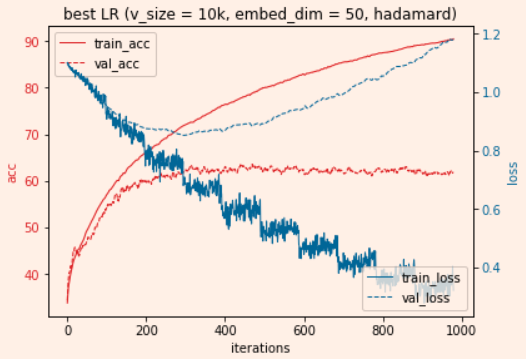

The following function may be useful to you to accomplish this, but you are also welcome to modify it or write your own plotting code.

In [33]:
import matplotlib.pyplot as plt

def plot_over_training(per_epoch_metrics, title_name):
    """Utility function to plot train/val accuracies and losses.

    @param per_epoch_metrics: a dictionary of lists, where each list represents a metric over the
      course of training.
    @param title_name: String to show on the plot title.
    """
    t = np.arange(0, len(per_epoch_metrics['train_accs']))
    train_acc = per_epoch_metrics['train_accs']
    val_acc = per_epoch_metrics['val_accs']
    train_loss = per_epoch_metrics['train_losses']
    val_loss = per_epoch_metrics['val_losses']

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('acc', color=color)
    ax1.plot(t, train_acc, color=color, linewidth=1, label = 'train_acc')
    ax1.plot(t, val_acc, color=color, linestyle='dashed', linewidth=1, label = 'val_acc')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend(loc='upper left')
    ax2 = ax1.twinx() 

    color = 'tab:blue'
    ax2.set_ylabel('loss', color=color)  # we already handled the x-label with ax1
    ax2.plot(t, train_loss, color=color, linewidth=1, label = 'train_loss')
    ax2.plot(t, val_loss, color=color, linestyle='dashed', linewidth=1, label = 'val_loss')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.legend(loc='lower right')
    fig.tight_layout() 
    plt.title(title_name)
    plt.show()

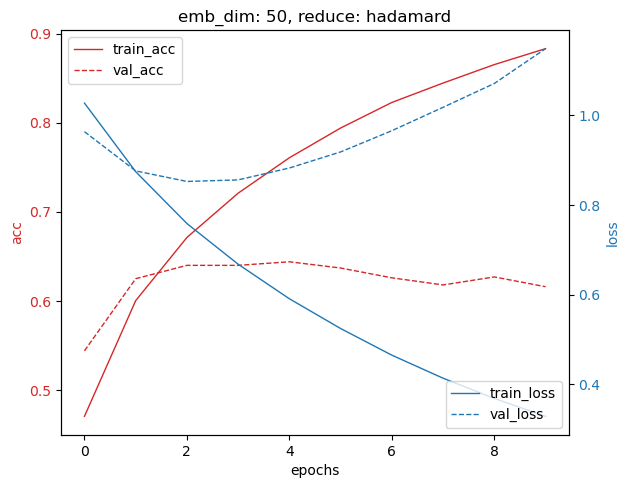

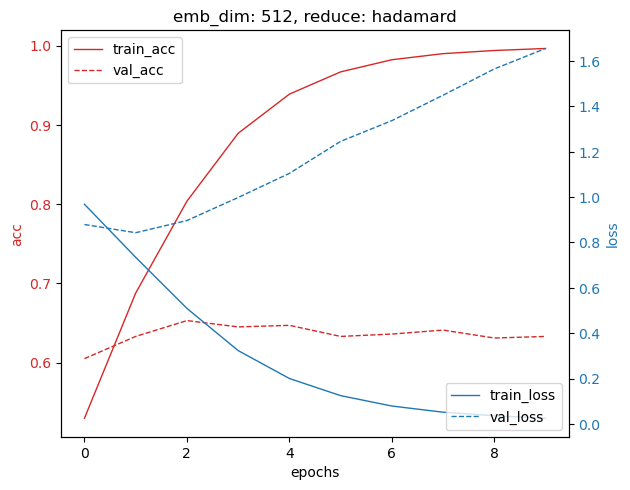

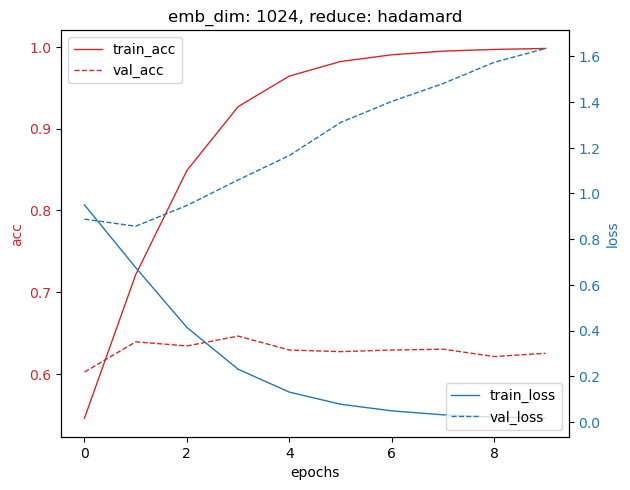

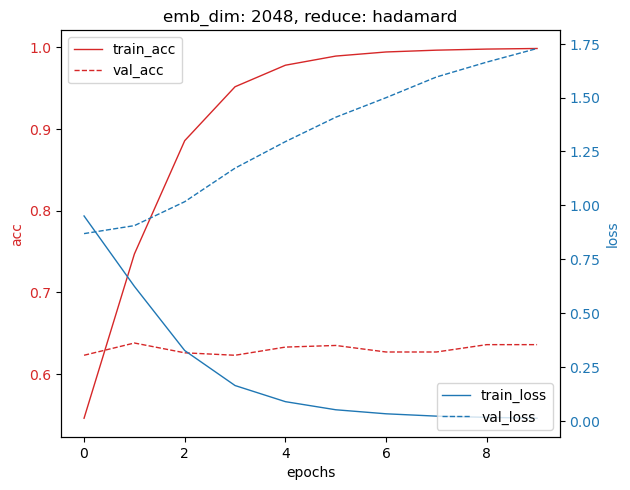

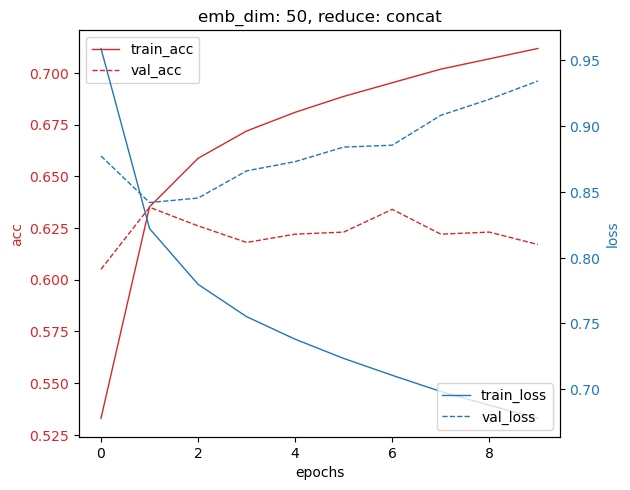

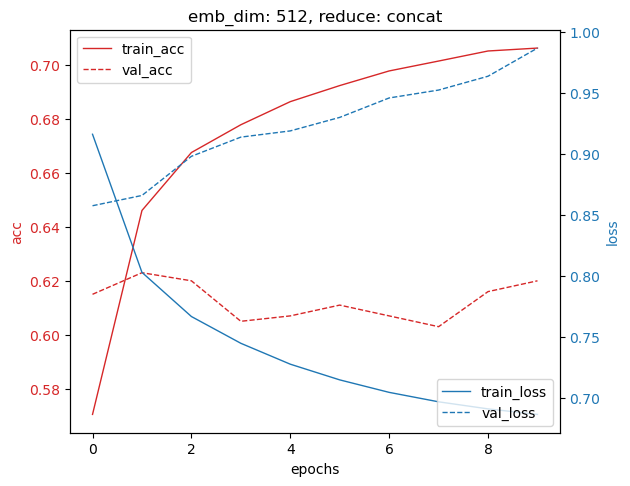

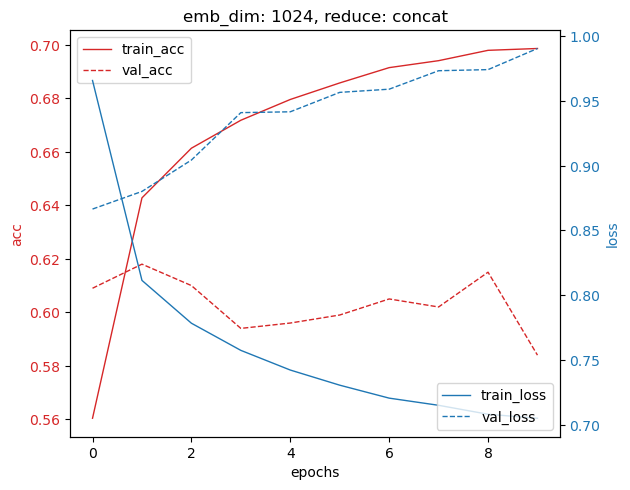

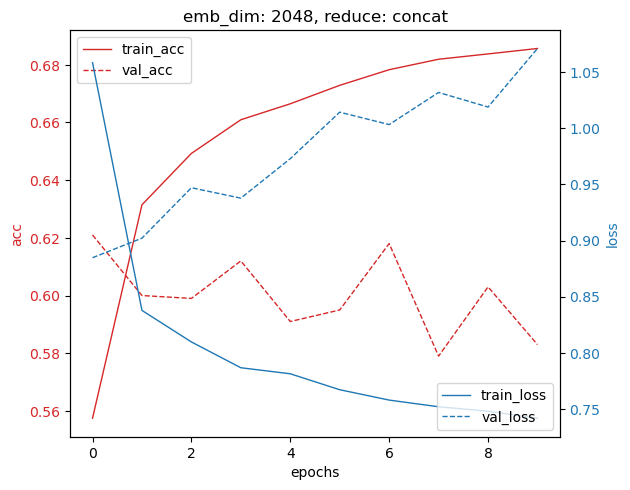

In [34]:
plot_over_training(res_50_hadamard, 'emb_dim: 50, reduce: hadamard')
plot_over_training(res_512_hadamard, 'emb_dim: 512, reduce: hadamard')
plot_over_training(res_1024_hadamard, 'emb_dim: 1024, reduce: hadamard')
plot_over_training(res_2048_hadamard, 'emb_dim: 2048, reduce: hadamard')

plot_over_training(res_50_concat, 'emb_dim: 50, reduce: concat')
plot_over_training(res_512_concat, 'emb_dim: 512, reduce: concat')
plot_over_training(res_1024_concat, 'emb_dim: 1024, reduce: concat')
plot_over_training(res_2048_concat, 'emb_dim: 2048, reduce: concat')

**Written 2:** (4 pts)   
Take your best model based on validation performace and report its validation accuracy:

#### Ans:
- Best model) emb_dim: 512, reduce: hadamard, validation accuracy: 0.653

Best model) emb_dim: 512, reduce: hadamard, validation accuracy: 0.653


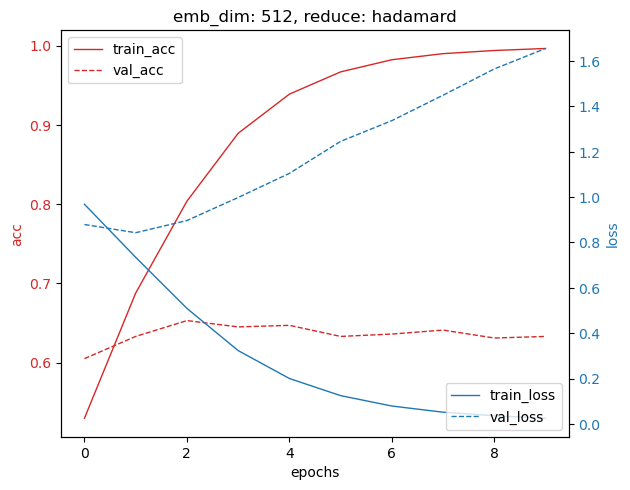

In [37]:
print('Best model) emb_dim: 512, reduce: hadamard, validation accuracy:', res_512_hadamard['val_accs'][2])
plot_over_training(res_512_hadamard, 'emb_dim: 512, reduce: hadamard')

**Written 3:** (4 pts)

Highlight 3 correct and 3 incorrect predictions in this validation set. Describe why the model might have gotten the 3 incorrect predictions wrong.

- Ans) BOW doesn't consider context of the sentence. Therefore, there should be some incorrect result


- Case index: 0  
    Hypothesis:  man driving his car past a statue  
    Premise:  a maintenance worker walking past a statue  
    Ground Truth:  contradiction  
    Prediction:  neutral  
    : The model may not see any relationship between a man and a maintenance worker. So the model would predicted as neutral. However, based on the context, if man is a maintenance worker, this sentence is a contradiction as driving and walking can be interpreted as an opposite


- Case index: 1
    Hypothesis:  a skier died by red flag  
    Premise:  a skier <UNK> by a red flag  
    Ground Truth:  contradiction  
    Prediction:  entailment  
    : This is very hard for the model to predict <UNK>. The model would predicted <UNK> as any word that can be very similar to the word in Hypothesis. Therefore the model predicted as entailment. 

    
- Case index: 9
    Hypothesis:  a skateboarder goes up the hill  
    Premise:  a skateboarder goes down a railing  
    Ground Truth:  contradiction  
    Prediction:  entailment  
    : As mentioned, BOW doesn't consider the context of the sentence. The model might not able to figure out the relationship between 'up' and 'down', and predicted as an entailment.

In [38]:
### Experiment 4
# - emb_dim = 512
# - reduce = 'hadamard'

# train_loss: 0.606, train_acc: 0.946, val_loss: 0.906, val_acc: 0.641

# max_vocab_size = 10000, batch_size = 1024 (already defined and used at previous codes)
emb_dim = 512
reduce = 'hadamard'
learning_rate = 0.01
num_epochs = 10

model = LogisticsModelPytorch(len(id2token), emb_dim, len(set(label_index_train)), reduce)

# Criterion and Optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# run model
res_512_hadamard = train(model)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch 1) train_loss: 0.973, train_acc: 0.526, val_loss: 0.885, val_acc: 0.606
epoch 2) train_loss: 0.730, train_acc: 0.690, val_loss: 0.854, val_acc: 0.637
epoch 3) train_loss: 0.502, train_acc: 0.808, val_loss: 0.910, val_acc: 0.631
epoch 4) train_loss: 0.318, train_acc: 0.890, val_loss: 1.024, val_acc: 0.626
epoch 5) train_loss: 0.195, train_acc: 0.941, val_loss: 1.138, val_acc: 0.630
epoch 6) train_loss: 0.121, train_acc: 0.967, val_loss: 1.250, val_acc: 0.623
epoch 7) train_loss: 0.077, train_acc: 0.982, val_loss: 1.385, val_acc: 0.623
epoch 8) train_loss: 0.051, train_acc: 0.990, val_loss: 1.483, val_acc: 0.618
epoch 9) train_loss: 0.034, train_acc: 0.994, val_loss: 1.596, val_acc: 0.607
epoch 10) train_loss: 0.024, train_acc: 0.997, val_loss: 1.683, val_acc: 0.612


In [41]:
# checking some examples 
for batch, (hypo, len_hypo, prem, len_prem, label) in enumerate(newsgroup_loaders['validation']):
    # run the model for validation set and also evaluatwe
    prob = model(hypo, len_hypo, prem, len_prem)
    pred = torch.argmax(prob, dim=1)

In [42]:
# correct index: 0,1,4
# incorrect index: 2,3,5
# 0 : entailment, 1: neutral, 2: contradiction

class_label = {0: 'neutral', 1: 'entailment', 2: 'contradiction'}
pred[:10], label[:10]

(tensor([0, 1, 2, 0, 2, 1, 2, 1, 1, 1]),
 tensor([2, 2, 2, 0, 0, 1, 2, 1, 0, 2]))

In [45]:
## details of predictions
correct_idx = [2,3,5]
incorrect_idx = [0,1,9]

for idx in correct_idx:
    print('Correct predictions')
    print('Case index:', idx)
    print('Hypothesis: ', ' '.join([id2token[x] for x in hypo[idx][:len_hypo[idx]]]))
    print('Premise: ', ' '.join([id2token[x] for x in prem[idx][:len_prem[idx]]]))
    print('Ground Truth: ', class_label[label[idx].item()])
    print('Prediction: ', class_label[pred[idx].item()])
    print()

for idx in incorrect_idx:
    print('Incorrect predictions')
    print('Case index:', idx)
    print('Hypothesis: ', ' '.join([id2token[x] for x in hypo[idx][:len_hypo[idx]]]))
    print('Premise: ', ' '.join([id2token[x] for x in prem[idx][:len_prem[idx]]]))
    print('Ground Truth: ', class_label[label[idx].item()])
    print('Prediction: ', class_label[pred[idx].item()])
    print()
    

Correct predictions
Case index: 2
Hypothesis:  a man sits on a wooden floor building a model ship
Premise:  a man in a brown jacket white shirt and dark slacks is holding a book with his finger on the
Ground Truth:  contradiction
Prediction:  contradiction

Correct predictions
Case index: 3
Hypothesis:  a guy <UNK> his knife to butcher the <UNK>
Premise:  a man in a kitchen leaning over a table sharpening a knife
Ground Truth:  neutral
Prediction:  neutral

Correct predictions
Case index: 5
Hypothesis:  a man does some work while sitting outside at a park
Premise:  an overweight man in a blue and black hooded sweatshirt works on a laptop computer outdoors
Ground Truth:  entailment
Prediction:  entailment

Incorrect predictions
Case index: 0
Hypothesis:  man driving his car past a statue
Premise:  a maintenance worker walking past a statue
Ground Truth:  contradiction
Prediction:  neutral

Incorrect predictions
Case index: 1
Hypothesis:  a skier died by red flag
Premise:  a skier <UNK> 